Here I want to generate means over a day or over a number of days so that I can generate a plot with the mean data

Good website for information on earth data resolution : https://gisjames.wordpress.com/2016/04/27/deciding-how-many-decimal-places-to-include-when-reporting-latitude-and-longitude/ <br> 

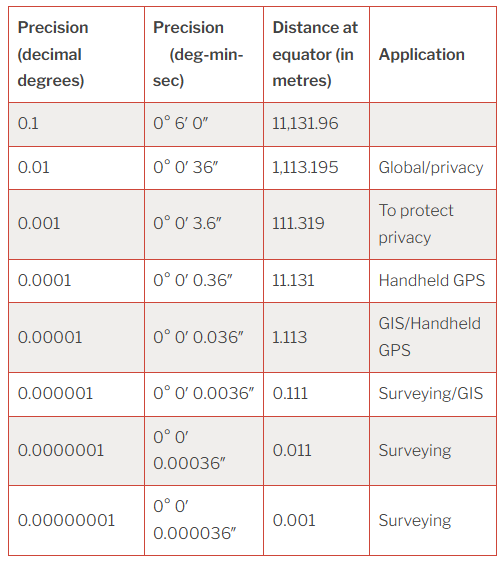



Using round(0) which is rounding to the nearest whole number for lat and lon requires s = 40 on the plot <br>
round(0) reduces number of data points on test day from ~ 55k to ~8.6k (111km grid resolution)<br>
round (1) reduces data points from ~55k to ~30k (11km grid resolution) <br>

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Point
import geopandas as gpd
from cartopy.io import shapereader
import glob
import pandas as pd

In [65]:
# Load data
f_name = 'Data/ESACCI-GHG-L2-CH4-CO-TROPOMI-WFMD-20240301-fv3.nc'
ds = xr.open_dataset(f_name)

# Extract and clean
lat = ds['latitude']
lon = ds['longitude']
xch4 = ds['xch4']

# Mask invalid values
valid = (xch4 > 0) & (~xch4.isnull())
lat_valid = lat.where(valid, drop=True)
lon_valid = lon.where(valid, drop=True)
xch4_valid = xch4.where(valid, drop=True)

# Round lat/lon to 2 decimal places to bin similar points
lat_rounded = lat_valid.round(0)
lon_rounded = lon_valid.round(0)

# Convert to pandas DataFrame
df = pd.DataFrame({
    'lat': lat_rounded.values,
    'lon': lon_rounded.values,
    'xch4': xch4_valid.values
})

# Drop any remaining NaNs
df = df.dropna()

# Group by lat-lon and compute mean
mean_df = df.groupby(['lat', 'lon'], as_index=False).mean()


In [66]:
mean_df

,lat,lon,xch4
0,-82.0,-78.0,1787.500732
1,-82.0,-77.0,1771.128296
2,-82.0,-76.0,1757.657104
3,-82.0,-74.0,1776.281738
4,-82.0,-71.0,1776.522705
...,...,...,...
8657,68.0,130.0,1920.491211
8658,68.0,131.0,1916.073120
8659,68.0,132.0,1912.342896
8660,68.0,133.0,1923.888062


### Plot the mean_df

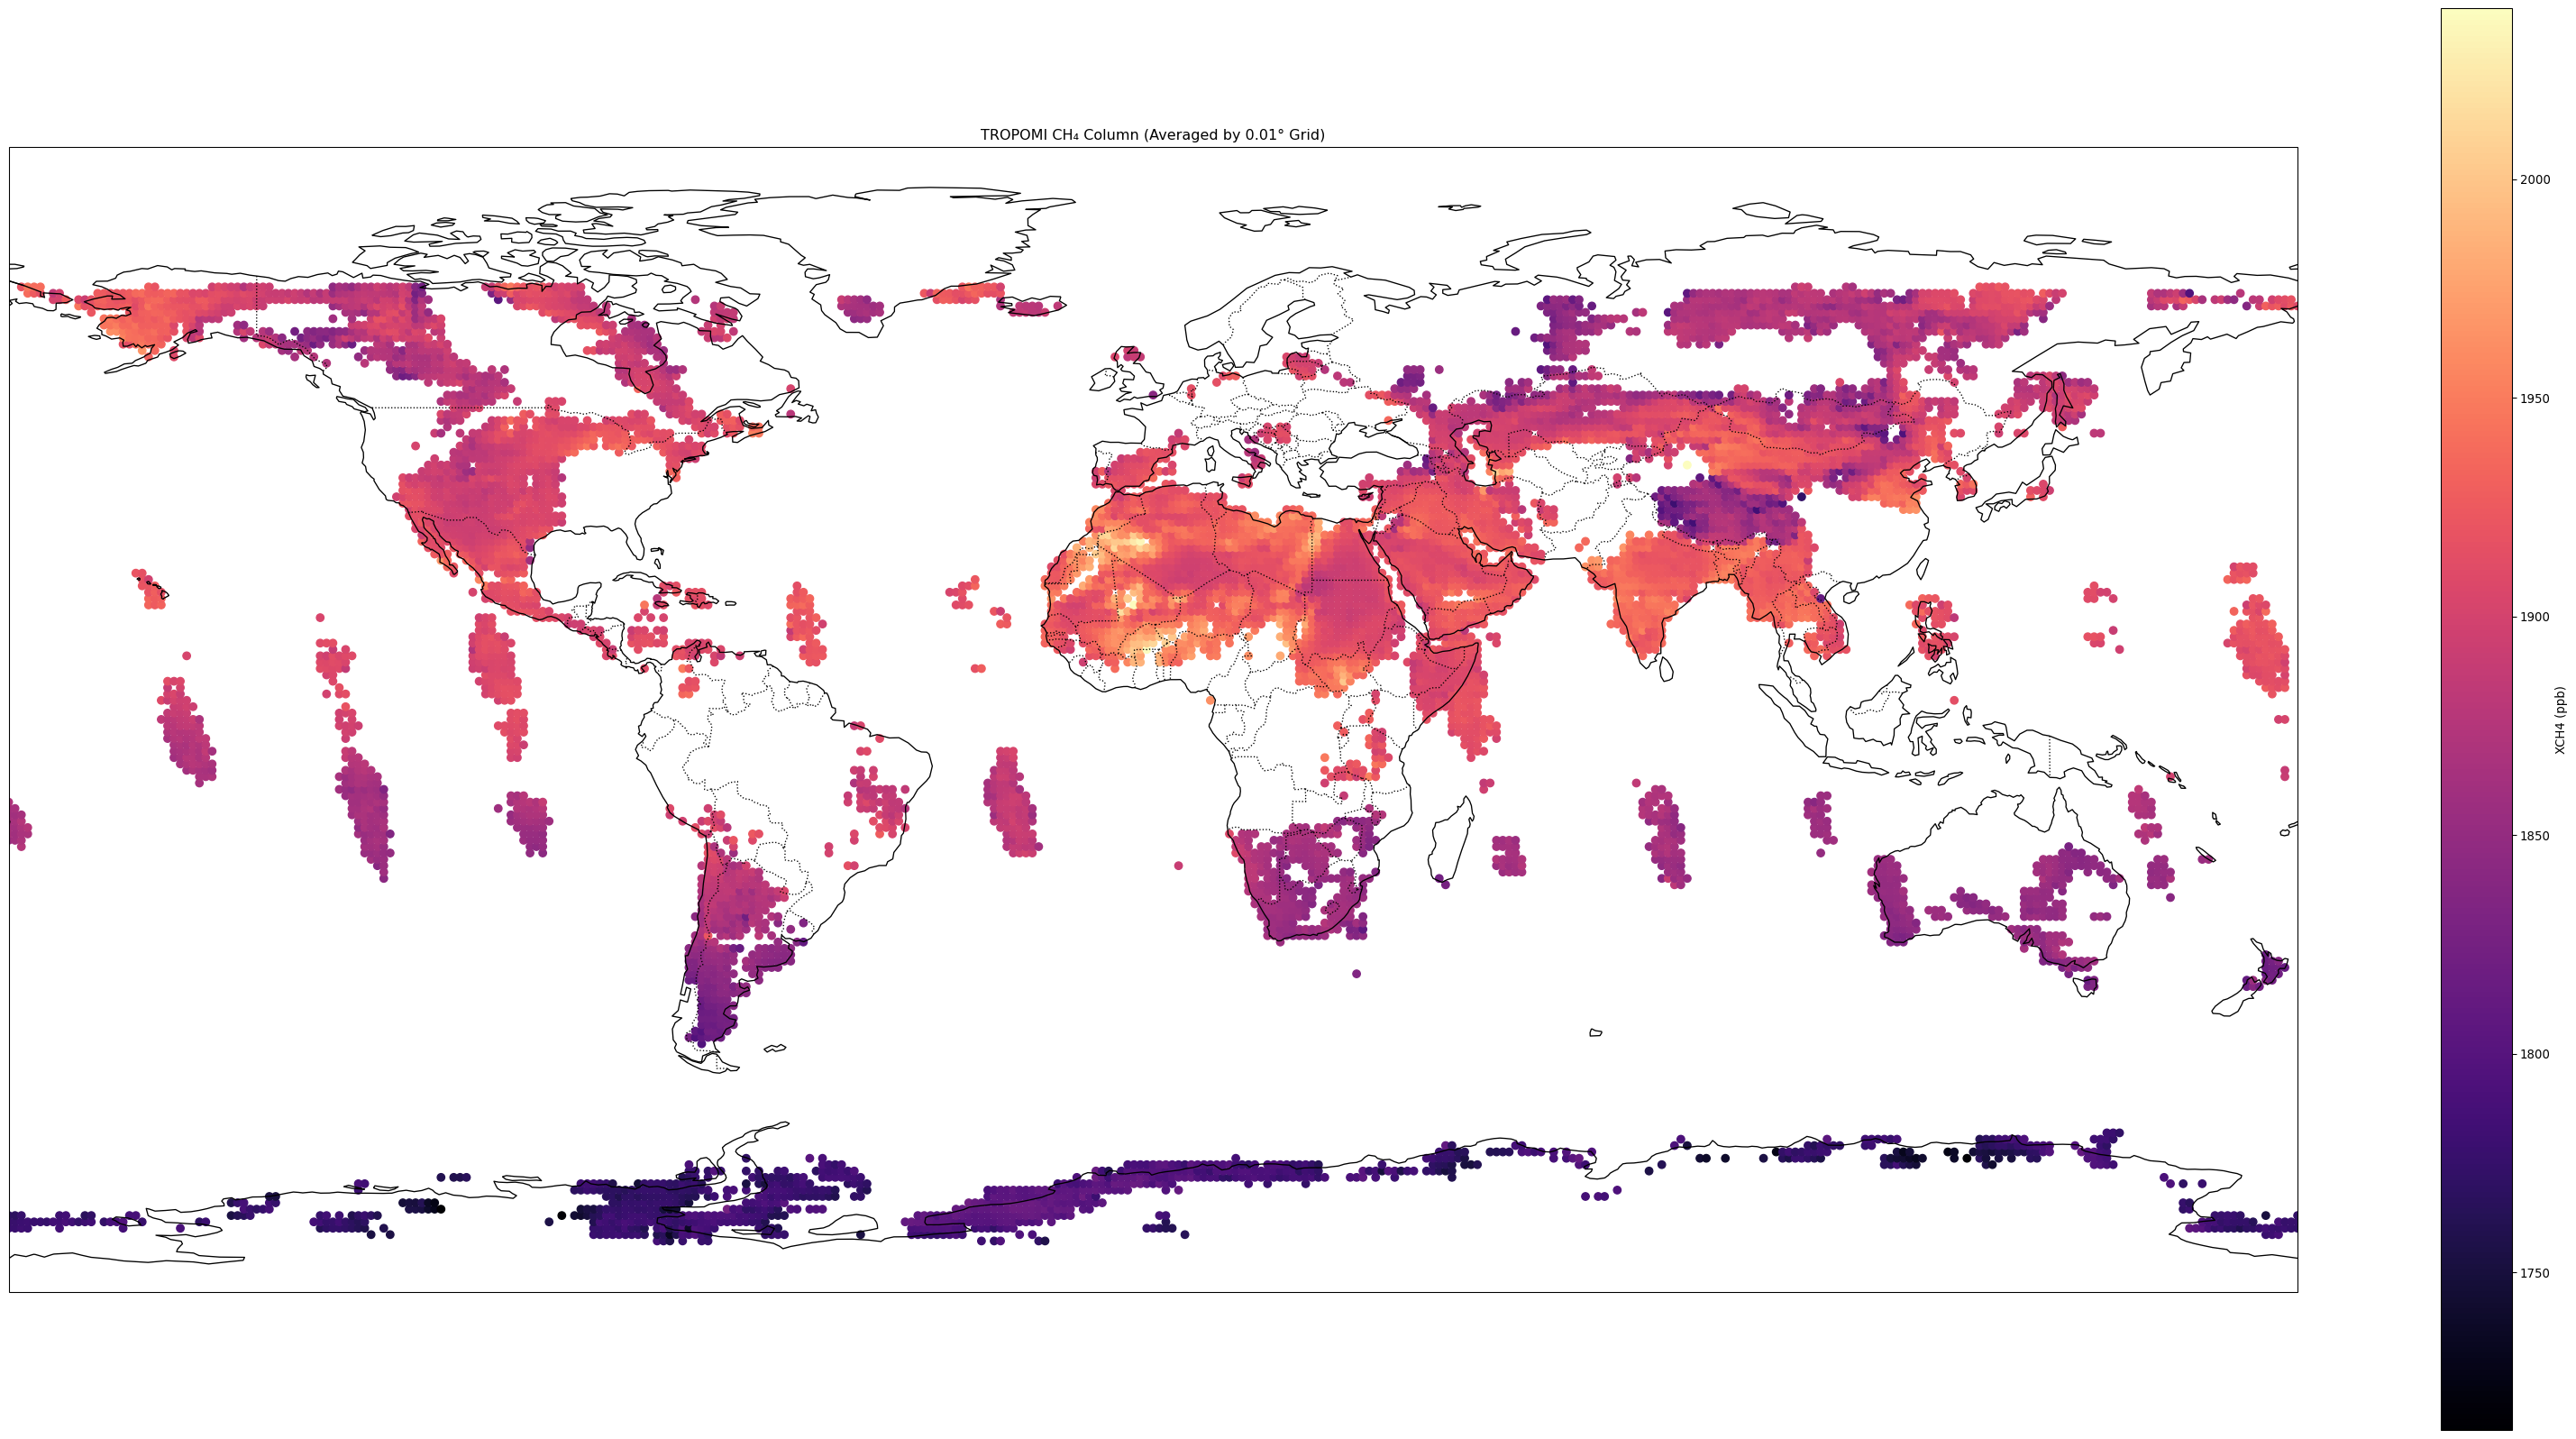

In [62]:
dpi = 96
width_in = 4096 / dpi
height_in = 2048 / dpi

fig = plt.figure(figsize=(width_in, height_in), dpi=dpi)

ax = plt.axes(projection=ccrs.PlateCarree())

sc = ax.scatter(
    mean_df['lon'], mean_df['lat'],
    c=mean_df['xch4'],
    s=40,
    cmap="magma",
    transform=ccrs.PlateCarree()
)

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.set_global()

plt.colorbar(sc, label="XCH4 (ppb)")
plt.title("TROPOMI CH₄ Column (Averaged by 0.01° Grid)")

# plt.savefig('mean_figure_large_rounding_xLscatter_size.png', dpi = 96)
plt.show()